<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Assuming nltk is set up with necessary datasets
import nltk
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses"

In [8]:
# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]
    return tokens



In [14]:
# Assuming all your text files are in the 'inauguration_speeches' directory
directory = my_path
all_files = os.listdir(directory)

sentences = [] # This will store all sentences needed for training

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        # Preprocess and tokenize the text
        tokens = preprocess_text(text)
        sentences.append(tokens)

In [ ]:
# sentences[5]

In [34]:
##How many CPU cores are availabe in Colab?
!cat /proc/cpuinfo | grep processor | wc -l

2


In [18]:
# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.save("presidential_speeches_word2vec.model")




In [22]:
# After training, you can use the model to find similar words, etc.
model.wv.most_similar('freedom',topn=2)

[('world', 0.9999240040779114), ('people', 0.9999042749404907)]

In [33]:
# Example words
word1 = "women"
word2 = "vote"
# word3="liberty"

# Get the vector for each word
vector1 = model.wv[word1]
vector2 = model.wv[word2]
# vector3=model.wv[word3]

# Add the vectors
added_vector = vector1 + vector2#+vector3

# You can now use the resulting vector to find similar words, for example
similar_words = model.wv.similar_by_vector(added_vector,topn=5)

print(similar_words)


[('women', 0.9995911121368408), ('great', 0.9993134140968323), ('political', 0.9992879629135132), ('without', 0.999281644821167), ('authority', 0.9992674589157104)]


In [35]:
# Extract all word vectors, this example uses a subset for clarity
words = list(model.wv.index_to_key[:100])  # Adjust the slice for the number of words you want
word_vectors = [model.wv[word] for word in words]


In [37]:
import numpy as np
from sklearn.decomposition import PCA

# Convert word vectors into a 2D array of shape (number_of_words, dimensions_of_vectors)
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors_matrix)


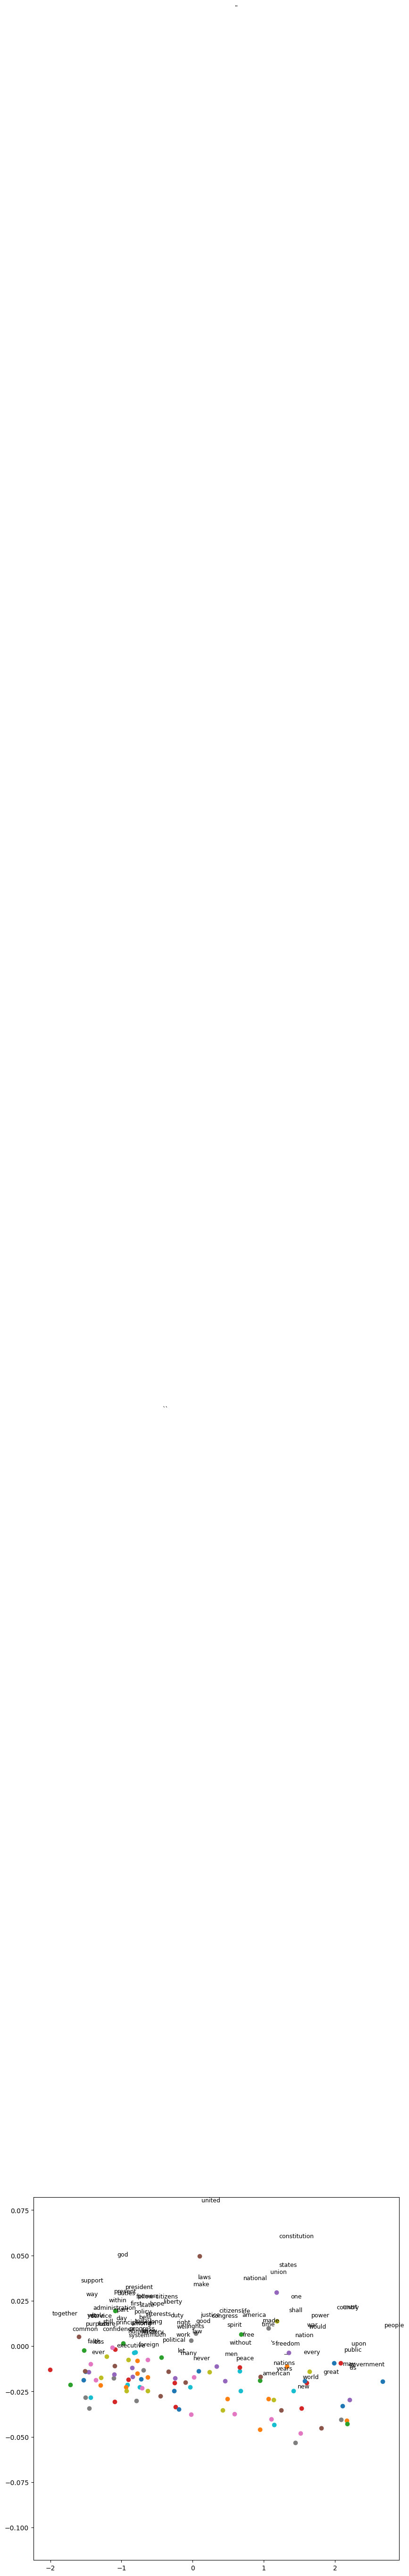

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Calculate the median of the y-values
med_y = np.median([vec[1] for vec in word_vectors_2d])

# Setting the vertical extent around the mean to not exceed 0.2
# This means the window will go from mean_y - 0.1 to mean_y + 0.1
plt.ylim(med_y - 0.1, med_y + 0.1)


for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0]+0.03, word_vectors_2d[i, 1]+0.03, word, fontsize=9)
plt.show()
